In [2]:
import scipy
import numpy as np
import pandas as pd
import pandasql 
import seaborn as sns

import sys
sys.path.append("C:/Users/Kunle/Documents/JIGSAW/crp_extracts")
import os
os.chdir("C:/Users/Kunle/Documents/JIGSAW/crp_extracts")

from matplotlib import pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest

from datetime import datetime
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [3]:
sampleCSV = '010218USCanadaRiskRulesNegVariance.csv'
pd.set_option('display.max_columns', 500)

In [4]:
def readCSV(csvFile, enc):
    df = pd.read_csv(csvFile, encoding = enc, dtype = str) #use utf-8
    return df

def cleanColumnNames(df):
    df.rename(columns = {'CPM Compliance ': 'Willa CPM Compliance', 
                             'CPM Compliance': 'Willa CPM Compliance', 
                             'Complex program': 'IPPF Complex Program'}, inplace = True)
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')
    return df

def removeOrigNA(df):
    df.replace({',': '', '#DIV/0!': '', '%': '', 'N/A': np.nan}, regex=True, inplace=True)
    return df

def toNumeric(df):
    return df.apply(pd.to_numeric)

def rescaleDF(df):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(df) # returns an np.array
    
    dfScaled = pd.DataFrame(scaled, columns = df.columns)
    return dfScaled

def oneHotEncode(df):
    df1Hot = pd.get_dummies(df, columns = df.columns.tolist())
    #print (df1Hot)
    return df1Hot

def extractOrRemoveByColumn(X, val, columnName, choice):
    if choice == 'remove' and val == 'NA':
        X= X[X[columnName].isnull() == False] #.notnull()
        return X
    elif choice == 'remove':
        X= X[X[columnName] != val]
        return X
    elif choice == 'extract' and val == 'NA':
        X= X[X[columnName].isnull()]
        return X
    elif choice == 'extract':
        X= X[X[columnName] == val]
        return X
        
def valueCount(X, value):
    valueCount = {}
    if value == 'NA':
        for col in X.columns:
            colValue = 0
            for val in X[col].isnull():
                if val == True:
                    colValue += 1
            valueCount[col] = [colValue, '{:0.2f}%'.format((float(colValue)/len(X))*100)]
        return valueCount
    else:
        for col in X.columns:
            colValue = 0
            for val in X[col] == value:
                if val == True:
                    colValue += 1
            valueCount[col] = [colValue, '{:0.2f}%'.format((float(colValue)/len(X))*100)]
        return valueCount
    
def fillColWithMedian(X):
    for col in X.columns:
        X[col] = X[col].fillna(X[col].median())
    return X

def removeOutliers(X):
    for col in X.columns:
        X[col] = replaceOutlier(X[col])
    return X

def dataframeSelector(X, columnList):
    return pd.DataFrame(X, columns=columnList)

def removeSpecificAndPutMedian(data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val) 
    return New

def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))


def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote])):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote])):
        tfOutlier = list(zip(x, func(x)))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(list(zip(data, vote)), columns=['excessive', 'outlier'])
    if replace == 'median':
        replace = x.excessive.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in list(zip(data, vote)) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    excessiveNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            excessiveNew.append(replace)
        else:
            excessiveNew.append(x.iloc[i][0])
    return excessiveNew

In [5]:
# create separate filters for different subsets and columns field types
# Use pmnotesid
numerical = ['percentagecontractors', 'total#ofpeopleonproject', 
             'plancost', 'planrevenue', 'plangp%', 'plangp', 
             'lengthofproject(yr)']

categorical = ['pmnotesid','country', 'globalbuyinggroup', 'cluster', 'practice', 'ippfsector(s&d)', 
               'ippfsector(gboverlay)', 'ippfindustrys&d', 'brandpenotesid', 'gbsgrowthplatform']

targets = ['itdptdexcessivenegativevariance']#, 'itdptdexcessivevariance%']

allNum = numerical + targets
allCat = categorical

In [6]:
#read in data
df = readCSV(sampleCSV, 'latin-1')

In [7]:
#clean numeric data
cleanColumnNames(df)
dfNum = dataframeSelector(df, allNum)
removeOrigNA(dfNum)
dfNumNoID = toNumeric(dfNum)
dfNumNoIDNoNA = fillColWithMedian(dfNumNoID)
dfNumNoIDNoNANoOutliers = removeOutliers(dfNumNoIDNoNA)
dfNumNoIDNoNANoOutliers.head()

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:96: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:96: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\ipykernel\__main__.py:98: RuntimeWarning: invalid value encountered in greater


,percentagecontractors,total#ofpeopleonproject,plancost,planrevenue,plangp%,plangp,lengthofproject(yr),itdptdexcessivenegativevariance
0,0.000000,0.0,818794.0,11224839.31,0.927055,10406045.31,3.00,1
1,0.035714,56.0,0.0,0.00,0.313529,0.00,3.00,0
2,0.000000,0.0,0.0,70000.00,1.000000,21637.00,7.75,1
3,0.122449,0.0,0.0,0.00,0.313529,0.00,3.00,0
4,0.000000,0.0,0.0,0.01,1.000000,0.01,3.00,1


In [8]:
#clean categorical data
dfCat = dataframeSelector(df, allCat)
dfCatOneHotNoID = oneHotEncode(dfCat)

In [9]:
# join num and cat
dfID = df['wbsid']
dfAll = pd.concat([dfID, dfNumNoIDNoNANoOutliers, dfCatOneHotNoID], axis=1)
#dfAll = pd.merge(dfNumCleanedID, dfCatOneHotID, on = 'wbsid', how = 'left')
dfAll.head()

,wbsid,percentagecontractors,total#ofpeopleonproject,plancost,planrevenue,plangp%,plangp,lengthofproject(yr),itdptdexcessivenegativevariance,pmnotesid_Aaron Bauhs/New York/IBM,pmnotesid_Aaron Hunter/Cincinnati/IBM,pmnotesid_Aaron Miles/Chicago/IBM,pmnotesid_Aaron Myhre/US/IBM,pmnotesid_Abha Pandey/Charlotte/IBM,pmnotesid_Abhi Tiwari1/Canada/IBM,pmnotesid_Abhishake Gera/India/IBM,pmnotesid_Abraham Mahmood/San Francisco/IBM,pmnotesid_Adam A Miller/Fairfax/IBM,pmnotesid_Adam Solaiman/US/IBM,pmnotesid_Aditya Lahiri/India/IBM,pmnotesid_Adriana Delor/Los Angeles/IBM,pmnotesid_Aidan J. Moran - ecxio/UK/IBM,pmnotesid_Ajay Y Joshi/India/IBM,pmnotesid_Ajit Natu/Carson City/IBM,pmnotesid_Ajoy K Datta/India/IBM,pmnotesid_Akilesh R Iyer/India/IBM,pmnotesid_Al Dundas/Markham/IBM,pmnotesid_Alain A Tardif/Quebec/IBM,pmnotesid_Alain Dubuc/Quebec/IBM,pmnotesid_Alan L Do/Philadelphia/IBM,pmnotesid_Alan Smith/Toronto/IBM,pmnotesid_Alarice R Cesareo/New York/IBM,pmnotesid_Albert B Lou/San Francisco/IBM,pmnotesid_Albert Carmanico/Ontario/IBM,pmnotesid_Alberto Castano-pardo/San Antonio/IBM,pmnotesid_Aleem Hooda/Markham/IBM,pmnotesid_Alex Gonzales/Dallas/IBM,pmnotesid_Alex Reyes/Ontario/IBM,pmnotesid_Alex Trinh/Houston/IBM,pmnotesid_Alexendre Jeanjean/Boston/IBM,pmnotesid_Alexis McDonald/Ontario/IBM,pmnotesid_Alfonso Cerezales/Ottawa/IBM,pmnotesid_Ali A Dogar/Toronto/IBM,pmnotesid_Ali Parsa/New York/IBM,pmnotesid_Ali Shakil/Markham/IBM,pmnotesid_Alison Cox/Toronto/IBM,pmnotesid_Allan Caldwell/Toronto/IBM,pmnotesid_Allen Plaskovsky/Piscataway/IBM,pmnotesid_Allison L Smith/Atlanta/IBM,pmnotesid_Amadally Hosseinbukus/US/IBM,pmnotesid_Aman Gupta/Raleigh/IBM,pmnotesid_Amanda L Thurston/Armonk/IBM,pmnotesid_Ambareen Ahmed/Chicago/IBM,pmnotesid_Amber Sundell/Minneapolis/IBM,pmnotesid_Ambrish Das1/India/IBM,pmnotesid_Amish Desai/Burlington/IBM,pmnotesid_Amit C Wagh/Beaverton/IBM,pmnotesid_Amit Dhar/Ontario/IBM,pmnotesid_Amit Dube1/India/IBM,pmnotesid_Amit Gupta3/US/IBM,pmnotesid_Amit K Chaturvedi/Atlanta/IBM,pmnotesid_Amit K Mehta/India/IBM,pmnotesid_Amit Ketkar/San Jose/IBM,pmnotesid_Amit Mankekar/CanWest/IBM,pmnotesid_Amitabh Jain2/US/IBM,pmnotesid_Amlan Pattnaik/Atlanta/IBM,pmnotesid_Amol S Agrawal/India/IBM,pmnotesid_Amy Maloche1/US/IBM,pmnotesid_Amy Osorio/Lincoln/IBM,pmnotesid_Amy S Easterling/St Louis/IBM,pmnotesid_Ananda Reddy D/India/IBM,pmnotesid_Ananda Saha/CanWest/IBM,pmnotesid_Ananth S12/India/IBM,pmnotesid_Anastacia Clapper/Dallas/IBM,pmnotesid_Andre Ribeiro/Markham/IBM,pmnotesid_Andrew B Waxman/New York/IBM,pmnotesid_Andrew Bournos/Southbury/IBM,pmnotesid_Andrew J Demas/New York/IBM,pmnotesid_Andrew J Necastro/Schaumburg/IBM,pmnotesid_Andrew Ross/Canada/Contr/IBM,pmnotesid_Andy Bornstein/Atlanta/IBM,pmnotesid_Andy Jankowski/Indianapolis/IBM,pmnotesid_Andy Pittaway/UK/IBM,pmnotesid_Angie Evrovski/CanEast/IBM,pmnotesid_Angie R Zhu/Boulder/IBM,pmnotesid_Anil Gopala/US/IBM,pmnotesid_Anil Sawant/Philadelphia/IBM,pmnotesid_Anindya Ghosh/India/IBM,pmnotesid_Anirban Bhattacharyya1/US/IBM,pmnotesid_Anirban Biswas3/India/IBM,pmnotesid_Aniruddha Ghosh1/India/IBM,pmnotesid_Anita Hanley/Atlanta/IBM,pmnotesid_Ankit Rampuria/India/IBM,pmnotesid_Ankur Gupta11/India/IBM,pmnotesid_Ankur Gupta15/India/IBM,pmnotesid_Ann E Cantu/Dallas/IBM,pmnotesid_Ann Hunter/Spartanburg/IBM,pmnotesid_Ann Wannenwetsch/Mechanicsburg/IBM,pmnotesid_Anna E Dydzuhn/New York/IBM,pmnotesid_Anna Li/CanWest/IBM,pmnotesid_Annette Hamala/Houston/IBM,pmnotesid_Anshul Agrawal/Ontario/IBM,pmnotesid_Anshul Bhadoria/India/IBM,pmnotesid_Anthony C Minetti jr/Tampa/IBM,pmnotesid_Anthony J Brown/US/IBM,pmnotesid_Anthony L Rydell/New York/IBM,pmnotesid_Anthony Mercer/Salt Lake City/IBM,pmnotesid_Antoine M Wright/Miami/IBM,pmnotesid_Anu Thomas/India/IBM,pmnotesid_Anuj Gupta3/India/IBM,pmnotesid_Anupam Sarkar/Piscataway/IBM,pmnotesid_Anupam Varma/San Francisco/IBM,pmnotesid_Anurag Singh/India/IBM,pmnotesid_Arindam Sengupta/India/IBM,pmnotesid_Arjan Ligtenberg/US/IBM,pmnotesid_Art Liem/Southbury/IBM,pmn

In [10]:
def add_freq():
    ncount = len(dfAll)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

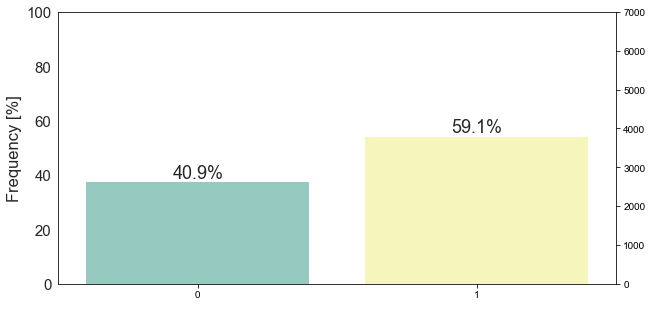

In [11]:
ax = sns.countplot(x = dfAll.itdptdexcessivenegativevariance, palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 20000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=7000)

add_freq()

plt.show()

### Train test split

In [12]:
X = dfAll.drop(['itdptdexcessivenegativevariance', 'wbsid'], axis=1)
y = dfAll.itdptdexcessivenegativevariance

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### PCA

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
sScaler = StandardScaler(copy=True, with_mean=True, with_std=True)

xScaled = sScaler.fit_transform(X_train)

forPca = pd.DataFrame(xScaled)

from sklearn.decomposition import PCA

pcaMod = PCA(n_components=2)

xPca = pcaMod.fit_transform(X)

xPcaDataframe = pd.DataFrame(xPca, columns=['PC1', 'PC2'])

xPcaDataframe['cat'] = y

In [16]:
xPcaDataframe.head()

,PC1,PC2,cat
0,1.031461e+07,5.773469e+06,1
1,-1.500450e+06,6.784253e+03,0
2,-1.437369e+06,4.340834e+04,1
3,-1.500450e+06,6.784253e+03,0
4,-1.500450e+06,6.784259e+03,1


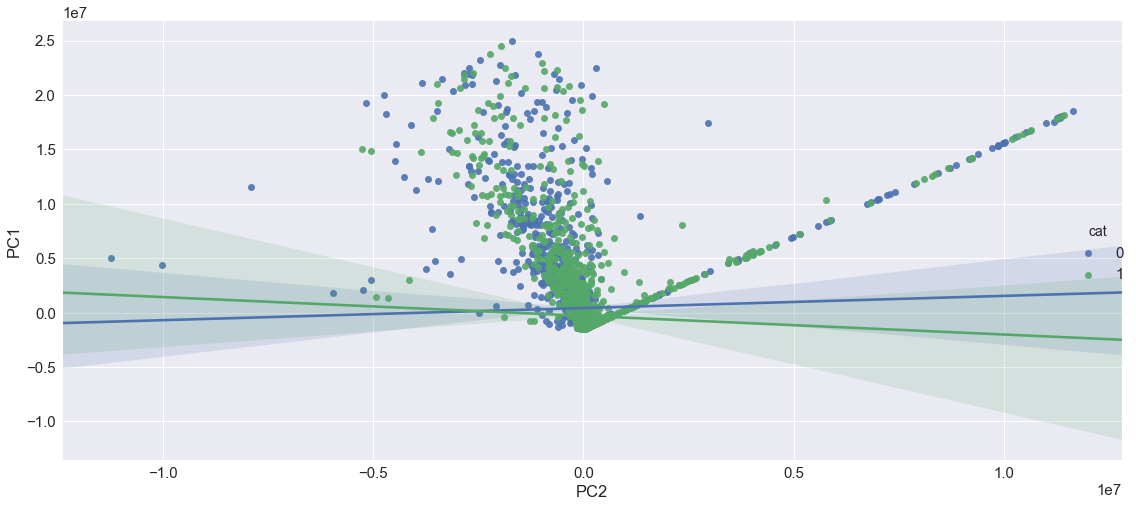

In [17]:
ax = sns.lmplot(data = xPcaDataframe, x='PC2', y='PC1', hue='cat', size=10, aspect=20, fit_reg=True,
               scatter_kws={'alpha': 0.9})
fig = plt.gcf()
fig.set_size_inches(15, 7)

In [18]:
#xPcaDataframe.head()
#xPcaDataframe.describe()
pcaMod.explained_variance_ratio_

array([0.90094521, 0.07056368])

In [19]:
xPcaDataframe.to_csv('PCADataFrame.csv', sep=',', encoding='latin-1')

### t-SNE

In [20]:
from sklearn.manifold import TSNE
import random

In [21]:
tsneMod = TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, learning_rate=50., n_iter=500,
               metric='euclidean', init='random', verbose=2, random_state=None)

In [22]:
n = 3250
X_data, X_none, y_data, y_none = train_test_split(X, y, test_size=(1-(n/float(len(dfAll)))))

In [23]:
xTsne = tsneMod.fit_transform(X_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.807s...
[t-SNE] Computed neighbors for 3250 samples in 10.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.502s
[t-SNE] Iteration 50: error = 18.6255932, gradient norm = 0.0094494 (50 iterations in 5.484s)
[t-SNE] Iteration 100: error = 14.1896429, gradient norm = 0.0025409 (50 iterations in 4.269s)
[t-SNE] Iteration 150: error = 13.2092810, gradient norm = 0.0015863 (50 iterations in 4.175s)
[t-SNE] Iteration 200: error = 12.7256775, gradient norm = 0.0010656 (50 iterations in 4.123s)
[t-SNE] Iteration 250: error = 12.4553738, gradient norm = 0.0008726 (50 iterations in 3.880s)
[t-SNE] KL divergence after 250 iterat

In [24]:
xTsneDataFrame = pd.DataFrame(xTsne, columns=['one', 'two'])

y_data.index = range(0,len(xTsneDataFrame))

xTsneDataFrame['cat'] = y_data

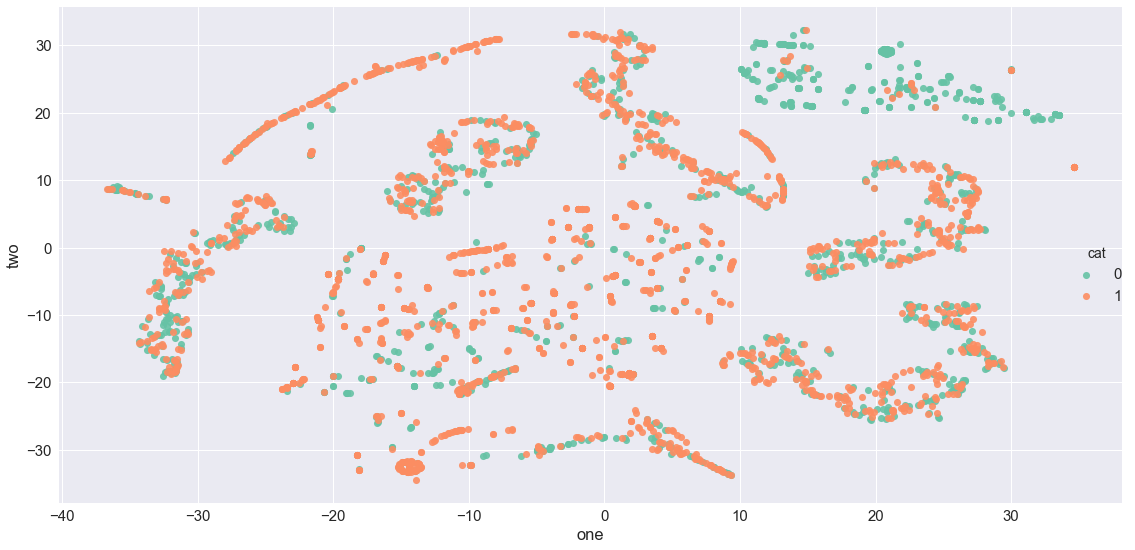

In [25]:
ax = sns.lmplot(data = xTsneDataFrame, x='one', y='two', hue='cat', size=70, aspect=5, fit_reg=False, palette='Set2',
               scatter_kws={"s": 50, 'alpha': 0.9})
fig = plt.gcf()
fig.set_size_inches(15, 7)

In [26]:
xTsneDataFrame.head()

,one,two,cat
0,-16.054409,8.333830,0
1,-31.726856,-7.180708,0
2,-14.381621,-32.487225,1
3,3.141904,29.511383,1
4,8.557630,-7.977043,1


In [27]:
def cvDictGen(functions, scr, X_train=X_train, y_train=y_train, cv=3, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[list(cvDict.keys())[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[list(cvDict.keys())[0]][1]))]
    return cvDictNormalized

### Predictions

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [29]:
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)

In [30]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=500,
                            multi_class='ovr', verbose=2)

In [31]:
adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0)

In [32]:
gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [33]:
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0)

In [34]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, rfMod], scr='roc_auc')

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.8s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


In [35]:
cvD

{'AdaBoostClassifier': [0.7845886309403372, 0.015587938914910273],
 'GradientBoostingClassifier': [0.827695818465548, 0.013771951634486473],
 'KNeighborsClassifier': [0.7680954691181702, 0.015563194588371711],
 'LogisticRegression': [0.6868274199417913, 0.010331367712100132],
 'RandomForestClassifier': [0.8087892827117145, 0.004479278435018197]}

In [36]:
cvDictNormalize(cvD)

{'AdaBoostClassifier': ['0.97', '3.48'],
 'GradientBoostingClassifier': ['1.02', '3.07'],
 'KNeighborsClassifier': ['0.95', '3.47'],
 'LogisticRegression': ['0.85', '2.31'],
 'RandomForestClassifier': ['1.00', '1.00']}

In [37]:
#XPCA = xPcaDataframe.drop('cat', axis=1)
#yPCA = xPcaDataframe.cat

In [38]:
#X_train, X_test, y_train, y_test = train_test_split(XPCA, yPCA, test_size=0.25)

In [39]:
#cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, rfMod], scr='roc_auc')

In [40]:
#cvD

In [41]:
#cvDictNormalize(cvD)

### Try AdaBoost, GradientBoost

In [42]:
from scipy.stats import randint

#### ADA

In [43]:
adaHyperParams = {'n_estimators': [10,50,100,200,400]}

In [44]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   0.7s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.6s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   2.8s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   2.8s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   2.9s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   5.7s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   5.7s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.5min finished


In [45]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 50}, 0.795585522218249)

#### GB

In [46]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [47]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] loss=exponential, max_depth=8, n_estimators=104 .................
[CV] .. loss=exponential, max_depth=8, n_estimators=104, total=  34.3s
[CV] loss=exponential, max_depth=8, n_estimators=104 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.6s remaining:    0.0s


[CV] .. loss=exponential, max_depth=8, n_estimators=104, total=  36.2s
[CV] loss=exponential, max_depth=8, n_estimators=104 .................
[CV] .. loss=exponential, max_depth=8, n_estimators=104, total=  32.8s
[CV] loss=deviance, max_depth=8, n_estimators=238 ....................
[CV] ..... loss=deviance, max_depth=8, n_estimators=238, total= 1.2min
[CV] loss=deviance, max_depth=8, n_estimators=238 ....................
[CV] ..... loss=deviance, max_depth=8, n_estimators=238, total= 1.3min
[CV] loss=deviance, max_depth=8, n_estimators=238 ....................
[CV] ..... loss=deviance, max_depth=8, n_estimators=238, total= 1.2min
[CV] loss=deviance, max_depth=8, n_estimators=60 .....................
[CV] ...... loss=deviance, max_depth=8, n_estimators=60, total=  20.5s
[CV] loss=deviance, max_depth=8, n_estimators=60 .....................
[CV] ...... loss=deviance, max_depth=8, n_estimators=60, total=  20.5s
[CV] loss=deviance, max_depth=8, n_estimators=60 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 14.1min finished


In [48]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 5, 'n_estimators': 122},
 0.8320348544353494)

#### LR

In [49]:
glmHyperParams = {'C': [10**-i for i in range(-5, 5)]}

In [50]:
gridSearchLR = RandomizedSearchCV(estimator=glmMod, param_distributions=glmHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=100000 ........................................................
[LibLinear][CV] ......................................... C=100000, total=   1.2s
[CV] C=100000 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[LibLinear][CV] ......................................... C=100000, total=   0.7s
[CV] C=100000 ........................................................
[LibLinear][CV] ......................................... C=100000, total=   0.5s
[CV] C=10000 .........................................................
[LibLinear][CV] .......................................... C=10000, total=   2.2s
[CV] C=10000 .........................................................
[LibLinear][CV] .......................................... C=10000, total=   0.5s
[CV] C=10000 .........................................................
[LibLinear][CV] .......................................... C=10000, total=   0.5s
[CV] C=1000 ..........................................................
[LibLinear][CV] ........................................... C=1000, total=   1.4s
[CV] C=1000 ..........................................................
[LibLinear][CV] ........................................... C=1000, total=   1.8s


C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ............................................ C=0.1, total=  17.2s
[CV] C=0.1 ...........................................................
[LibLinear][CV] ............................................ C=0.1, total=   0.2s
[CV] C=0.01 ..........................................................
[LibLinear]

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   9.4s
[CV] C=0.01 ..........................................................
[LibLinear]

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   7.4s
[CV] C=0.01 ..........................................................
[LibLinear][CV] ........................................... C=0.01, total=   0.2s
[CV] C=0.001 .........................................................
[LibLinear][CV] .......................................... C=0.001, total=   0.2s
[CV] C=0.001 .........................................................
[LibLinear]

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .......................................... C=0.001, total=   4.4s
[CV] C=0.001 .........................................................
[LibLinear][CV] .......................................... C=0.001, total=   0.2s
[CV] C=0.0001 ........................................................
[LibLinear]

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......................................... C=0.0001, total=   4.2s
[CV] C=0.0001 ........................................................
[LibLinear]

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......................................... C=0.0001, total=   4.3s
[CV] C=0.0001 ........................................................
[LibLinear][CV] ......................................... C=0.0001, total=   0.2s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


[LibLinear]

In [51]:
gridSearchLR.best_params_, gridSearchLR.best_score_

({'C': 1}, 0.6871890938470777)

#### RF

In [52]:
rfHyperParams = {'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [53]:
gridSearchRF = RandomizedSearchCV(estimator=rfMod, param_distributions=rfHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=442, max_depth=7 ...................................
[CV] .................... n_estimators=442, max_depth=7, total=   3.0s
[CV] n_estimators=442, max_depth=7 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] .................... n_estimators=442, max_depth=7, total=   2.9s
[CV] n_estimators=442, max_depth=7 ...................................
[CV] .................... n_estimators=442, max_depth=7, total=   2.9s
[CV] n_estimators=378, max_depth=9 ...................................
[CV] .................... n_estimators=378, max_depth=9, total=   3.2s
[CV] n_estimators=378, max_depth=9 ...................................
[CV] .................... n_estimators=378, max_depth=9, total=   3.2s
[CV] n_estimators=378, max_depth=9 ...................................
[CV] .................... n_estimators=378, max_depth=9, total=   3.3s
[CV] n_estimators=268, max_depth=9 ...................................
[CV] .................... n_estimators=268, max_depth=9, total=   2.5s
[CV] n_estimators=268, max_depth=9 ...................................
[CV] .................... n_estimators=268, max_depth=9, total=   2.3s
[CV] n_estimators=268, max_depth=9 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   37.0s finished


In [54]:
gridSearchRF.best_params_, gridSearchRF.best_score_

({'max_depth': 9, 'n_estimators': 378}, 0.8081678431909836)

#### Fit the best GB and ADA

#### Best GB

In [55]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [56]:
print(bestGbModFitted.feature_importances_[:25])

[0.01205528 0.01258064 0.06092378 0.04195067 0.06301746 0.05370894
 0.07046642 0.         0.         0.00130083 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


Text(0,0.5,'Deviance')

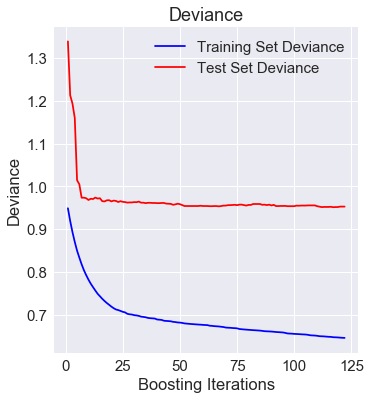

In [57]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((gridSearchGB.best_params_['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(bestGbModFitted.staged_predict(X_test)):
    test_score[i] = bestGbModFitted.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(gridSearchGB.best_params_['n_estimators']) + 1, bestGbModFitted.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gridSearchGB.best_params_['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

gbsgrowthplatform_DIGITAL STRATEGY AND iX
lengthofproject(yr)


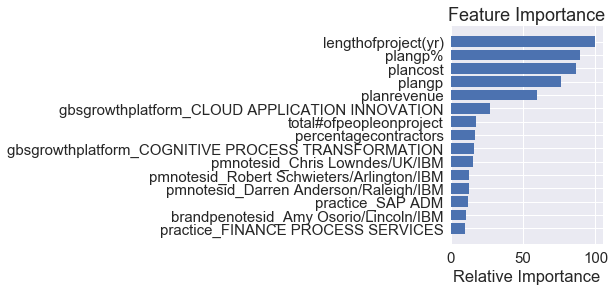

In [58]:
# Plot feature importance
feature_importance = bestGbModFitted.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
print (X_train.columns.values[-1])
plt.yticks(pos, X_train.columns.values[sorted_idx])
print (X_train.columns.values[sorted_idx][-1])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [59]:
sorted_idx[:15]

array([2097, 2185, 2115,  285,  986,  225, 2865,    0,    1, 2864,    3,
          5,    2,    4,    6], dtype=int64)

#### Best ADA

In [60]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [61]:
bestAdaModFitted.feature_importances_

array([0.02, 0.  , 0.06, ..., 0.  , 0.02, 0.  ])

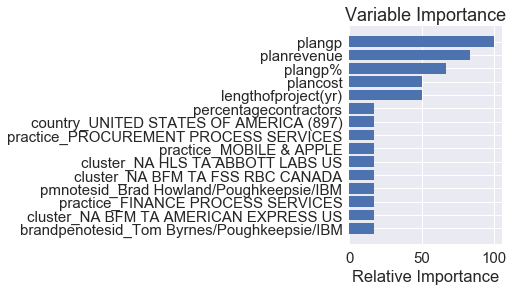

In [62]:
# Plot feature importance
feature_importance = bestAdaModFitted.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Best LR

In [63]:
bestGlmModFitted = gridSearchLR.best_estimator_.fit(X_train, y_train)

[LibLinear]

#### Best RF

In [64]:
bestRfModFitted = gridSearchRF.best_estimator_.fit(X_train, y_train)

In [65]:
print(bestRfModFitted.feature_importances_[:25])

[8.59570765e-03 8.52933072e-03 1.21013877e-01 1.18562235e-01
 4.46620868e-02 1.07264173e-01 5.35643985e-02 9.82849180e-06
 7.19271899e-05 2.62941643e-05 0.00000000e+00 8.60700568e-05
 2.47336740e-04 1.66550725e-04 1.25866938e-05 3.55955936e-05
 4.67169077e-05 3.59037046e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.51100661e-05 0.00000000e+00 5.42521841e-05
 0.00000000e+00]


gbsgrowthplatform_DIGITAL STRATEGY AND iX
plancost


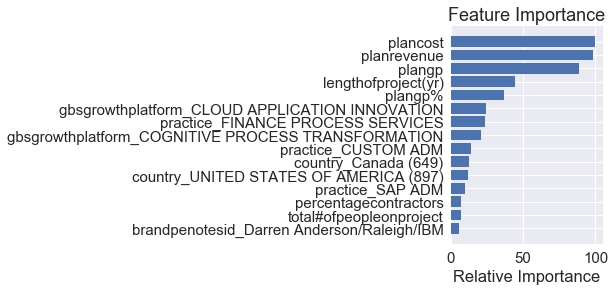

In [66]:
# Plot feature importance
feature_importance = bestRfModFitted.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
print (X_train.columns.values[-1])
plt.yticks(pos, X_train.columns.values[sorted_idx])
print (X_train.columns.values[sorted_idx][-1])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [67]:
cvDictHPO = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted, bestGlmModFitted, bestRfModFitted], scr='roc_auc')

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s finished


In [68]:
cvDictHPO

{'AdaBoostClassifier': [0.7955448819003584, 0.011723878277225881],
 'GradientBoostingClassifier': [0.832621354456316, 0.013154268928234614],
 'LogisticRegression': [0.687271613035224, 0.010604921571970377],
 'RandomForestClassifier': [0.8070213811178405, 0.013184897035962331]}

In [69]:
cvDictNormalize(cvDictHPO)

{'AdaBoostClassifier': ['0.99', '0.89'],
 'GradientBoostingClassifier': ['1.03', '1.00'],
 'LogisticRegression': ['0.85', '0.80'],
 'RandomForestClassifier': ['1.00', '1.00']}

Plot ROC curve with CV  
PlotCvRocCurve will plot the CV ROC curve with nfolds  
rocZeroOne will compute the best cut-off point for the classifiers

In [70]:
def plotCvRocCurve(X, y, classifier, nfolds=5):
    
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    #from sklearn.model_selection import StratifiedKFold
    import matplotlib.pyplot as plt
    from scipy import interp

    cv = StratifiedKFold(y, n_folds=nfolds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CV ROC curve')
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.set_size_inches(15,5)

    plt.show()

def rocZeroOne(y_true, y_predicted_porba):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted_porba[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])

    bestPoint = [fpr[dist.index(min(dist))], tpr[dist.index(min(dist))]]
    
    bestCutOff1 = thresholds[list(fpr).index(bestPoint[0])]
    bestCutOff2 = thresholds[list(tpr).index(bestPoint[1])]
    
    print ('\n' + 'Best point on the ROC: TPR = {:0.3f}%, FPR = {:0.3f}%'.format(bestPoint[1]*100, bestPoint[0]*100))
    print ('\n' + 'Best Cut-Off point: {:0.4f}'.format(bestCutOff1))

    plt.plot(dist)
    plt.xlabel('Index')
    plt.ylabel('Euclidean Distance to the perfect [0,1]')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

C:\Users\Yemisi\Anaconda3\envs\py3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


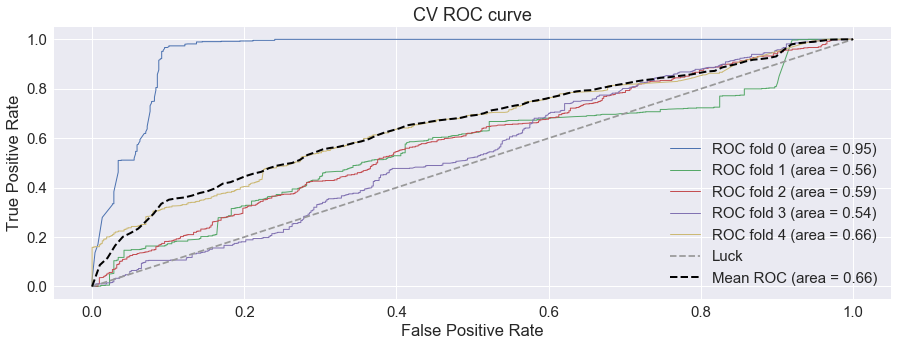

In [71]:
plotCvRocCurve(X, y, gridSearchGB.best_estimator_)


Best point on the ROC: TPR = 73.992%, FPR = 17.674%

Best Cut-Off point: 0.5142


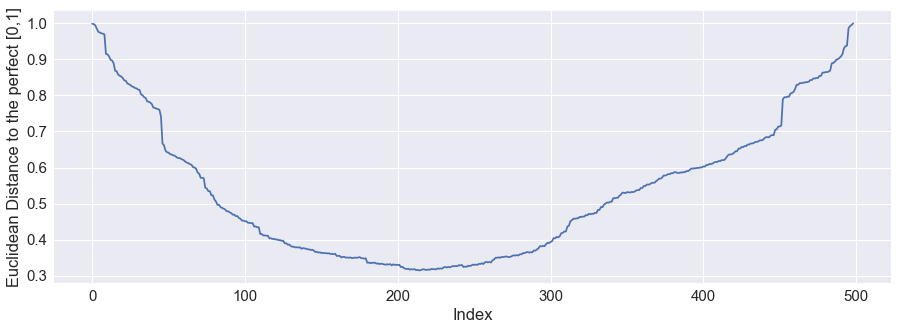

In [72]:
rocZeroOne(y_test, bestGbModFitted.predict_proba(X_test))

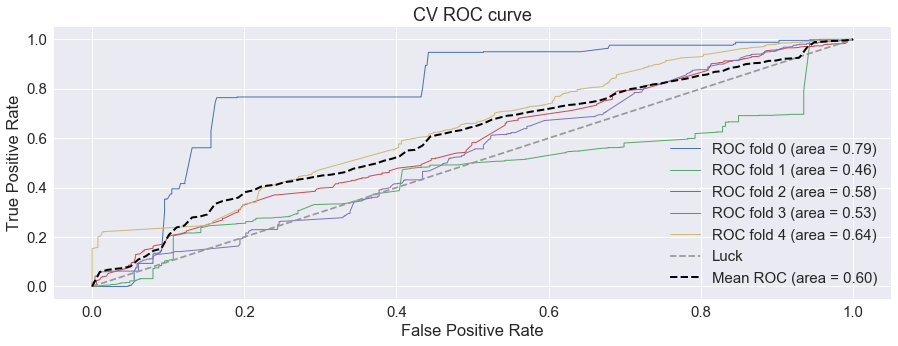

In [73]:
plotCvRocCurve(X, y, gridSearchAda.best_estimator_)


Best point on the ROC: TPR = 68.259%, FPR = 26.133%

Best Cut-Off point: 0.5014


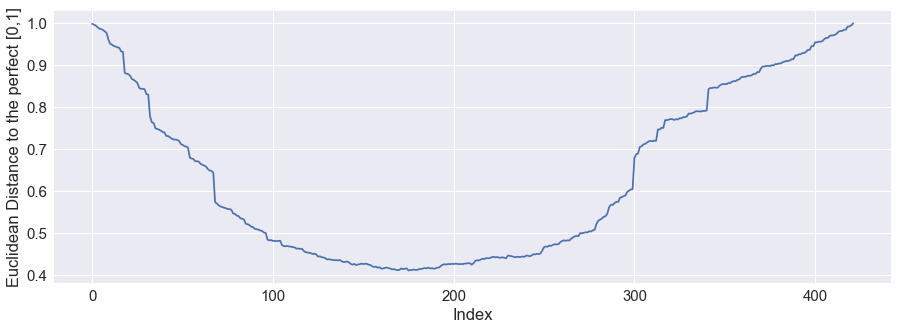

In [74]:
rocZeroOne(y_test, bestAdaModFitted.predict_proba(X_test))

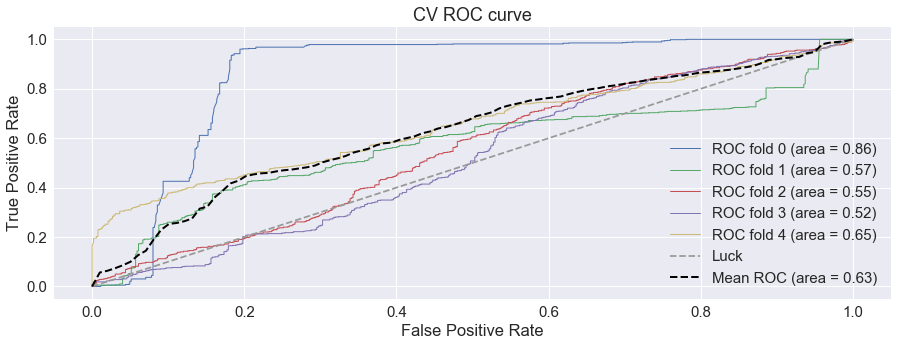

In [75]:
plotCvRocCurve(X, y, gridSearchRF.best_estimator_)


Best point on the ROC: TPR = 72.081%, FPR = 21.601%

Best Cut-Off point: 0.5539


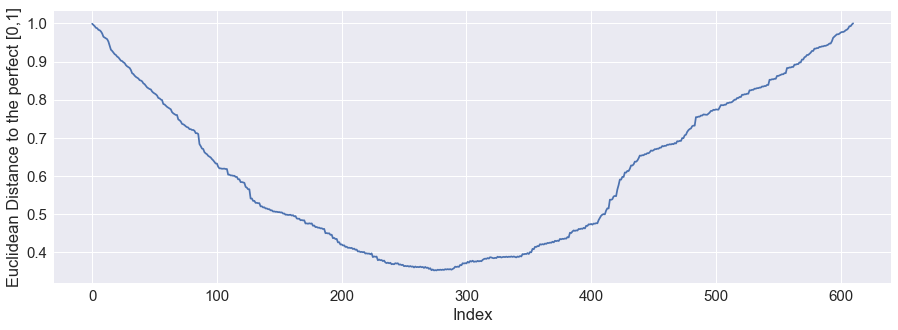

In [76]:
rocZeroOne(y_test, bestRfModFitted.predict_proba(X_test))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

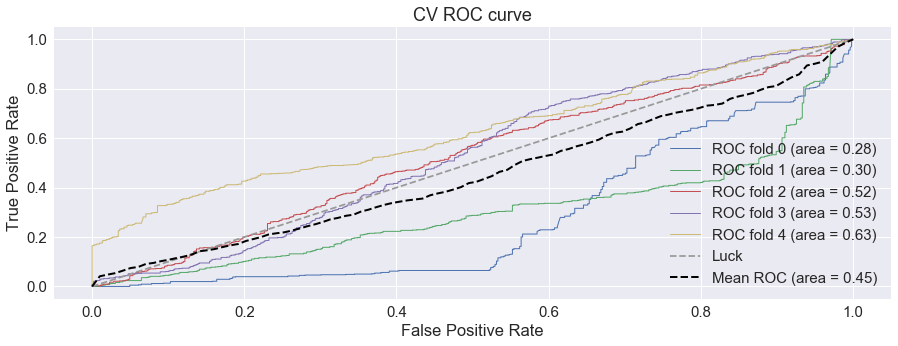

In [77]:
plotCvRocCurve(X, y, gridSearchLR.best_estimator_)


Best point on the ROC: TPR = 67.091%, FPR = 24.320%

Best Cut-Off point: 0.5428


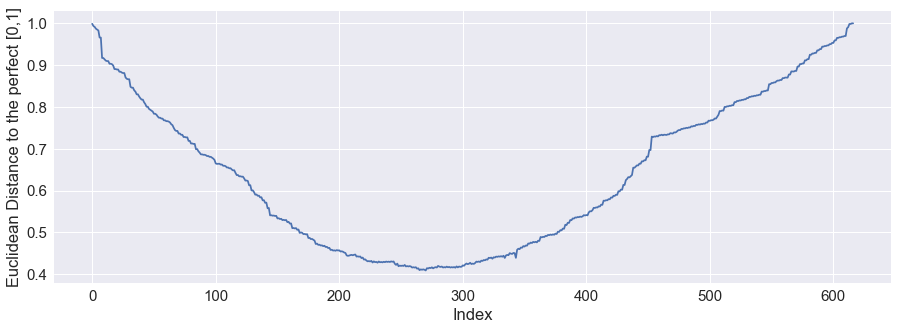

In [78]:
rocZeroOne(y_test, bestGlmModFitted.predict_proba(X_test))

#### Confusion matrix

In [79]:
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print ('Classification Report:\n')
    print (classification_report(y_test, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    def plot_confusion_matrix_plot(cm, title = 'Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(y_test.unique()))
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    print ('\n Confusion matrix, without normalization: \n')
    print (cm)
    plot_confusion_matrix_plot(cm=cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('\n Normalized confusion matrix \n')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')

def makePredThresh(fittedCls, thr = 0.5, X_test=X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

#### Make predicions from the GB model with the optimal threshold calculated before

In [89]:
pred = makePredThresh(bestGbModFitted, thr=0.5142)

Classification Report:

             precision    recall  f1-score   support

          0       0.69      0.82      0.75       662
          1       0.86      0.74      0.79       942

avg / total       0.79      0.77      0.78      1604


 Confusion matrix, without normalization: 

[[546 116]
 [247 695]]

 Normalized confusion matrix 

[[0.82477341 0.17522659]
 [0.26220807 0.73779193]]


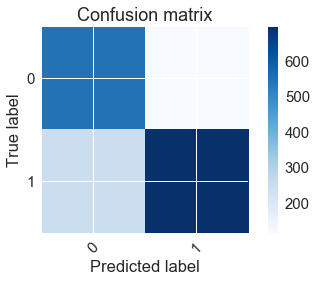

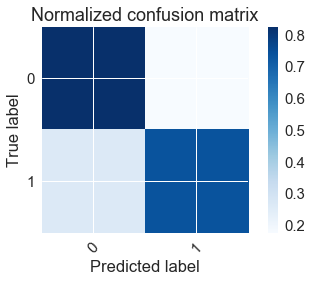

In [90]:
plot_confusion_matrix(y_test, pred)

#### Make predictions from the ADA model

In [91]:
predAda = makePredThresh(bestAdaModFitted, thr=0.5014)

Classification Report:

             precision    recall  f1-score   support

          0       0.61      0.76      0.68       662
          1       0.79      0.66      0.72       942

avg / total       0.72      0.70      0.70      1604


 Confusion matrix, without normalization: 

[[500 162]
 [317 625]]

 Normalized confusion matrix 

[[0.75528701 0.24471299]
 [0.33651805 0.66348195]]


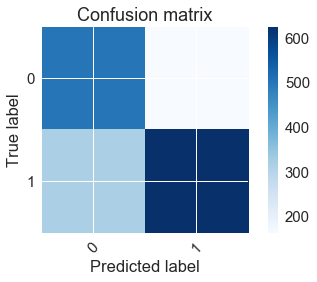

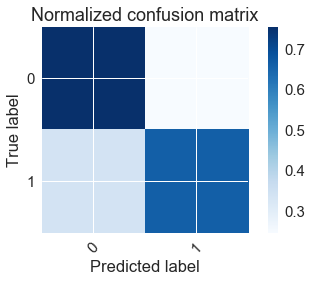

In [92]:
plot_confusion_matrix(y_test, predAda)

#### Make predictions from the RF model

In [93]:
predRF = makePredThresh(bestRfModFitted, thr=0.5539)

Classification Report:

             precision    recall  f1-score   support

          0       0.66      0.78      0.72       662
          1       0.83      0.72      0.77       942

avg / total       0.76      0.75      0.75      1604


 Confusion matrix, without normalization: 

[[519 143]
 [266 676]]

 Normalized confusion matrix 

[[0.78398792 0.21601208]
 [0.28237792 0.71762208]]


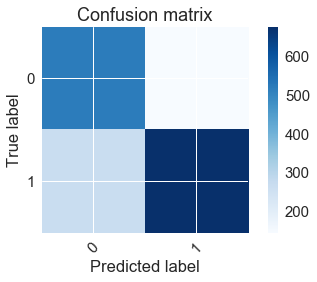

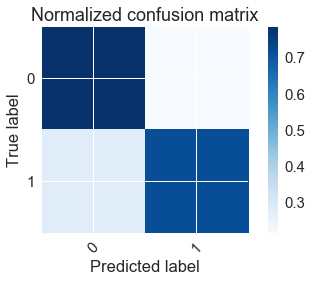

In [94]:
plot_confusion_matrix(y_test, predRF)

#### Make predictions from the LR model

In [95]:
predLR = makePredThresh(bestGlmModFitted, thr=0.5428)

Classification Report:

             precision    recall  f1-score   support

          0       0.62      0.76      0.68       662
          1       0.80      0.67      0.73       942

avg / total       0.72      0.70      0.71      1604


 Confusion matrix, without normalization: 

[[501 161]
 [313 629]]

 Normalized confusion matrix 

[[0.75679758 0.24320242]
 [0.33227176 0.66772824]]


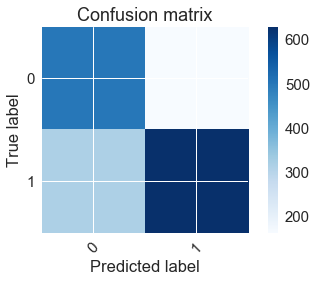

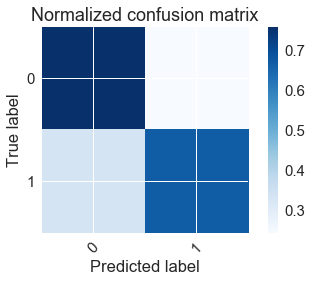

In [96]:
plot_confusion_matrix(y_test, predLR)

### Conclusion and notes

In [88]:
## Rate PMs on previous performance, add that column and retrain